In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
# Set display options
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# Connect to DuckDB
con = duckdb.connect()

In [2]:
# Summary of Kalshi Markets
kalshi_markets_summary = con.execute("""
    SELECT 
        count(*) as total_markets,
        count(CASE WHEN status = 'finalized' THEN 1 END) as finalized_markets,
        sum(volume) as total_volume
    FROM 'data/kalshi/markets/*.parquet'
""").df()

print("Kalshi Markets Summary:")
display(kalshi_markets_summary)

Kalshi Markets Summary:


,total_markets,finalized_markets,total_volume
0,7682445,7320904,1.803901e+10


In [3]:
# Summary of Polymarket Markets
poly_markets_summary = con.execute("""
    SELECT 
        count(*) as total_markets,
        avg(volume) as avg_volume_usd,
        sum(volume) as total_volume_usd
    FROM 'data/polymarket/markets/*.parquet'
""").df()

print("Polymarket Markets Summary:")
display(poly_markets_summary)

Polymarket Markets Summary:


,total_markets,avg_volume_usd,total_volume_usd
0,408863,121961.958126,4.986573e+10


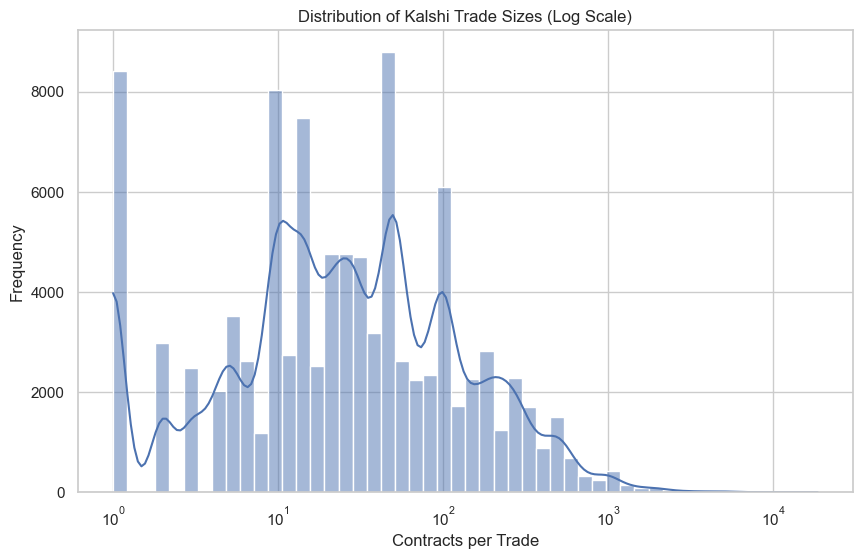

In [4]:
kalshi_trade_sizes = con.execute("""
    SELECT count as trade_size
    FROM 'data/kalshi/trades/*.parquet'
    WHERE count > 0
    LIMIT 100000
""").df()

plt.figure(figsize=(10, 6))
sns.histplot(kalshi_trade_sizes['trade_size'], bins=50, log_scale=True, kde=True)
plt.title("Distribution of Kalshi Trade Sizes (Log Scale)")
plt.xlabel("Contracts per Trade")
plt.ylabel("Frequency")
plt.show()

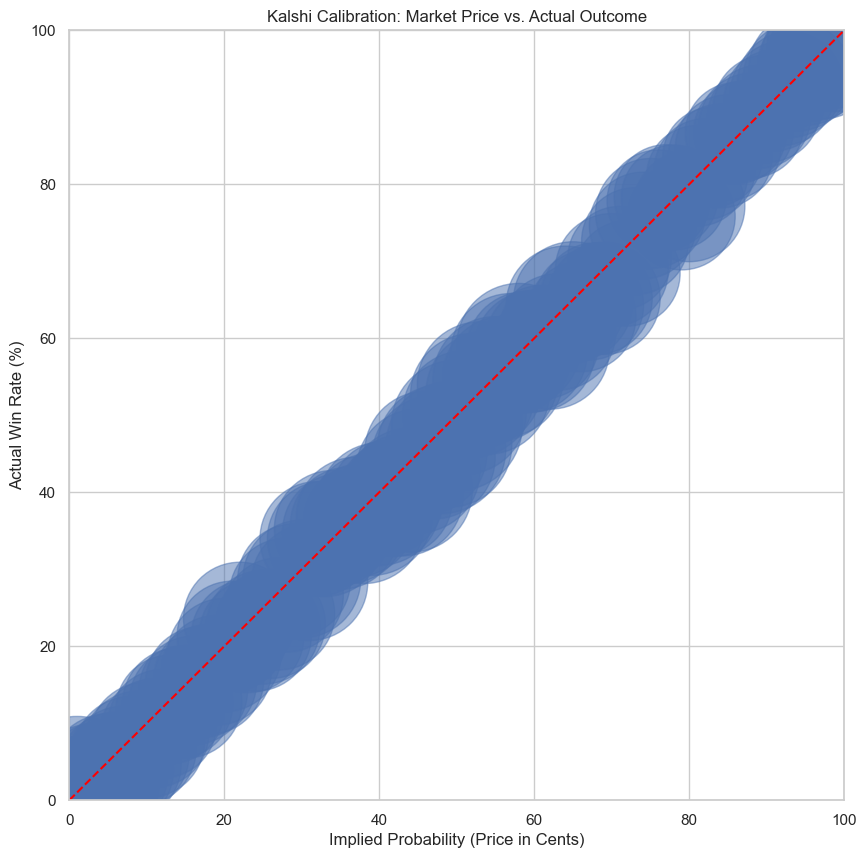

In [5]:
calibration_df = con.execute("""
    WITH resolved_trades AS (
        SELECT 
            CASE WHEN t.taker_side = 'yes' THEN t.yes_price ELSE t.no_price END as price,
            CASE WHEN t.taker_side = m.result THEN 1 ELSE 0 END as won
        FROM 'data/kalshi/trades/*.parquet' t
        JOIN 'data/kalshi/markets/*.parquet' m ON t.ticker = m.ticker
        WHERE m.status = 'finalized'
          AND m.result IN ('yes', 'no')
    )
    SELECT 
        price, 
        avg(won) as actual_win_rate,
        count(*) as sample_size
    FROM resolved_trades
    GROUP BY price
    ORDER BY price
""").df()

plt.figure(figsize=(10, 10))
plt.scatter(calibration_df['price'], calibration_df['actual_win_rate'] * 100, alpha=0.5, s=calibration_df['sample_size']/100)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')
plt.title("Kalshi Calibration: Market Price vs. Actual Outcome")
plt.xlabel("Implied Probability (Price in Cents)")
plt.ylabel("Actual Win Rate (%)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()